In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special



def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x


directory_1 = '/home/jin/data_CIV/'
# directory_1 = '/home/jin/data_inflow/'

rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

emit = np.arange(100,700,100)
emit = np.append([1,50],emit)

expand_vel = np.arange(0,1100,100)
# expand_vel = np.arange(-1000,0,100)

random_vel= [11.8,30,50,100,150]


# atom = [13,20,32,50,79]

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952



NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak



def gauss_func(F_c,x,x_0,sig):
    xx = np.linspace(x.min(),x.max(),1000)
    ss = (xx-x_0)/sig
    ex = np.zeros(len(xx))
    ex = F_c*np.exp(-ss**2/2)
    return  xx,ex

# plt.plot(del_V_space_g,yy_g)

3.39090e+13


In [2]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_A ) / C_IV_K_A ) * cc_k
    tv_h = ((xx-C_IV_H_A) / C_IV_H_A ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_A + C_IV_K_A)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >=lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

In [52]:
emit = 50
v_ran = 118
check= 0
for ii, index in enumerate(rr):
    index = int(index)
    for jj, expand in enumerate(expand_vel):
        if expand ==0:
            expand_v = '000'
            num_e = 0
        elif abs(expand) >= 1000:
            expand_v = int(expand / 10) 
            num_e = 3
        else :
            expand_v = expand 
            num_e = 2
        for kk,atom in enumerate(atom_N):
            atom = int(atom)
            path_sp= f'{directory_1}N_atom{atom}0E+{index}_Vexp{expand_v}E+0{num_e}_Vemit{emit}0E+01_tauD000E+00_Vran118E+01spec_com.dat'
        # 데이터 읽기
            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_sp_{atom}_{index}_{expand}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{atom}_{index}_{expand}'] = globals()[f'data_sp_{atom}_{index}_{expand}'][0]
            globals()[f'sp_{atom}_{index}_{expand}'] = globals()[f'data_sp_{atom}_{index}_{expand}'][1]

            # K and H line seperate
            lam_c = (C_IV_K_A+C_IV_H_A)/2
            # lam_c = (300/cc_k + 1)*C_IV_K_A
            #K line
            globals()[f'tot_x_K_{atom}_{index}_{expand}'] = globals()[f'sp_dlam_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] <= lam_c]
            globals()[f'tot_y_K_{atom}_{index}_{expand}'] = globals()[f'sp_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] <= lam_c]
            #H line
            globals()[f'tot_x_H_{atom}_{index}_{expand}'] = globals()[f'sp_dlam_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] >= lam_c]
            globals()[f'tot_y_H_{atom}_{index}_{expand}'] = globals()[f'sp_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] >= lam_c]

         


            globals()[f'tot_vx_K_{atom}_{index}_{expand}'] = (((globals()[f'tot_x_K_{atom}_{index}_{expand}'] - C_IV_K_A) /  C_IV_K_A)*cc_k).to_numpy()
            globals()[f'tot_vy_K_{atom}_{index}_{expand}']=  globals()[f'tot_y_K_{atom}_{index}_{expand}'].to_numpy()



            globals()[f'tot_vx_H_{atom}_{index}_{expand}'] = (((globals()[f'tot_x_H_{atom}_{index}_{expand}'] - C_IV_K_A) /  C_IV_K_A)*cc_k).to_numpy()
            globals()[f'tot_vy_H_{atom}_{index}_{expand}']=  globals()[f'tot_y_H_{atom}_{index}_{expand}'].to_numpy()

print(check)

0


In [53]:
print((200/cc_k + 1)*C_IV_K_A)

1549.219839191705


In [54]:
emit = 50
v_ran = 118
check= 0
for ii, index in enumerate(rr):
    index = int(index)
    for jj, expand in enumerate(expand_vel):
        if expand ==0:
            expand_v = '000'
            num_e = 0
        elif abs(expand) >= 1000:
            expand_v = int(expand / 10) 
            num_e = 3
        else :
            expand_v = expand 
            num_e = 2
        for kk,atom in enumerate(atom_N):
            atom = int(atom)
            path_sp= f'{directory_1}N_atom{atom}0E+{index}_Vexp{expand_v}E+0{num_e}_Vemit{emit}0E+01_tauD000E+00_Vran118E+01spec_com.dat'
        # 데이터 읽기
            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_sp_{atom}_{index}_{expand}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{atom}_{index}_{expand}'] = globals()[f'data_sp_{atom}_{index}_{expand}'][0]
            globals()[f'sp_{atom}_{index}_{expand}'] = globals()[f'data_sp_{atom}_{index}_{expand}'][2]

            # K and H line seperate
            lam_c = (C_IV_K_A+C_IV_H_A)/2
            # lam_c = (300/cc_k + 1)*C_IV_K_A
            #K line
            globals()[f'halo_x_K_{atom}_{index}_{expand}'] = globals()[f'sp_dlam_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] <= lam_c]
            globals()[f'halo_y_K_{atom}_{index}_{expand}'] = globals()[f'sp_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] <= lam_c]
            #H line
            globals()[f'halo_x_H_{atom}_{index}_{expand}'] = globals()[f'sp_dlam_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] >= lam_c]
            globals()[f'halo_y_H_{atom}_{index}_{expand}'] = globals()[f'sp_{atom}_{index}_{expand}'] [globals()[f'sp_dlam_{atom}_{index}_{expand}'] >= lam_c]

         


            globals()[f'halo_vx_K_{atom}_{index}_{expand}'] = (((globals()[f'halo_x_K_{atom}_{index}_{expand}'] - C_IV_K_A) /  C_IV_K_A)*cc_k).to_numpy()
            globals()[f'halo_vy_K_{atom}_{index}_{expand}']=  globals()[f'halo_y_K_{atom}_{index}_{expand}'].to_numpy()



            globals()[f'halo_vx_H_{atom}_{index}_{expand}'] = (((globals()[f'halo_x_H_{atom}_{index}_{expand}'] - C_IV_K_A) /  C_IV_K_A)*cc_k).to_numpy()
            globals()[f'halo_vy_H_{atom}_{index}_{expand}']=  globals()[f'halo_y_H_{atom}_{index}_{expand}'].to_numpy()

print(check)

0


In [55]:
def errorfunc_c(emit_0):
    tt = 2*special.erfc(-500/(np.sqrt(2)*emit_0)) + (C_IV_H_A/C_IV_K_A)*special.erfc(500/(np.sqrt(2)*emit_0))
    dd = 2*special.erfc(500/(np.sqrt(2)*emit_0)) + (C_IV_H_A/C_IV_K_A)*special.erfc(-500/(np.sqrt(2)*emit_0))
    result = tt/dd
    return result

print(errorfunc_c(300))

1.8604213672740935


Text(770, 0.6, '$\\rm V_{\\rm exp} = 400\\,\\rm km\\,s^{-1}$')

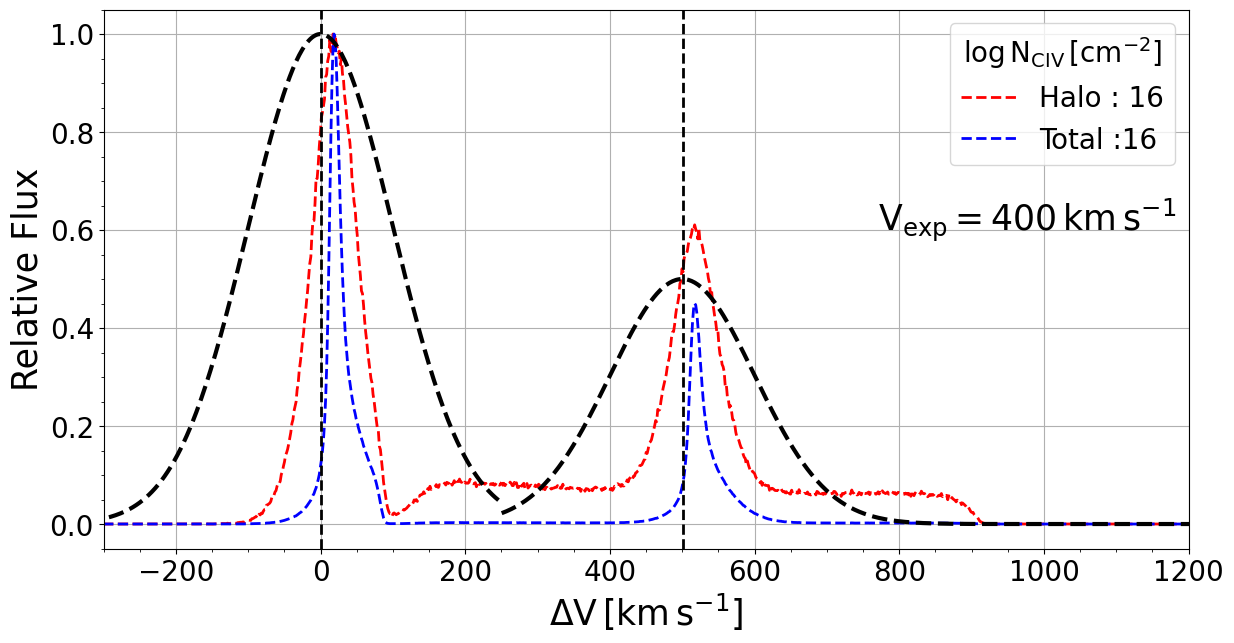

In [56]:
fig = plt.figure(1,figsize=(14,7))



atom ,v_ran,expand= 32 , 118, 400

index= 13
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# # normal_f = 1
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)


index = 16
normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)
normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=2,label=f'Total :{index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=2)



index = 14
expand = 0
xx_k,int_gau_K= gauss_func(normal_f,globals()[f'halo_vx_K_{atom}_{index}_{expand}'],0,100)
xx_h,int_gau_H= gauss_func(normal_f,globals()[f'halo_vx_H_{atom}_{index}_{expand}'],500,100)
plt.plot(xx_k,int_gau_K/normal_f,'k--',lw=3)
plt.plot(xx_h,int_gau_H/normal_f/2,'k--',lw=3)

plt.xlim(-300, 1200)
plt.minorticks_on()
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=1,title=r'$\log{{\rm N}_{\rm C IV}}\,[\rm cm ^{-2}]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=dv,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
ymin = -0.1
ymax = 1
expand = 400
plt.text(770, ymax*(0.6), f'$\\rm V_{{\\rm exp}} = {int(expand)}\\,\\rm km\\,s^{{-1}}$', size=25, fontweight='bold')

# plt.ylim(ymin,ymax)
#400 -> 2.1
#500 -> 0.97

# plt.savefig(f'/home/jin/바탕화면/DelV_gauss_source_density_{expand}km.pdf',bbox_inches='tight')

Text(770, 7.5, '$\\rm V_{\\rm out} = 500\\,\\rm km\\,s^{-1}$')

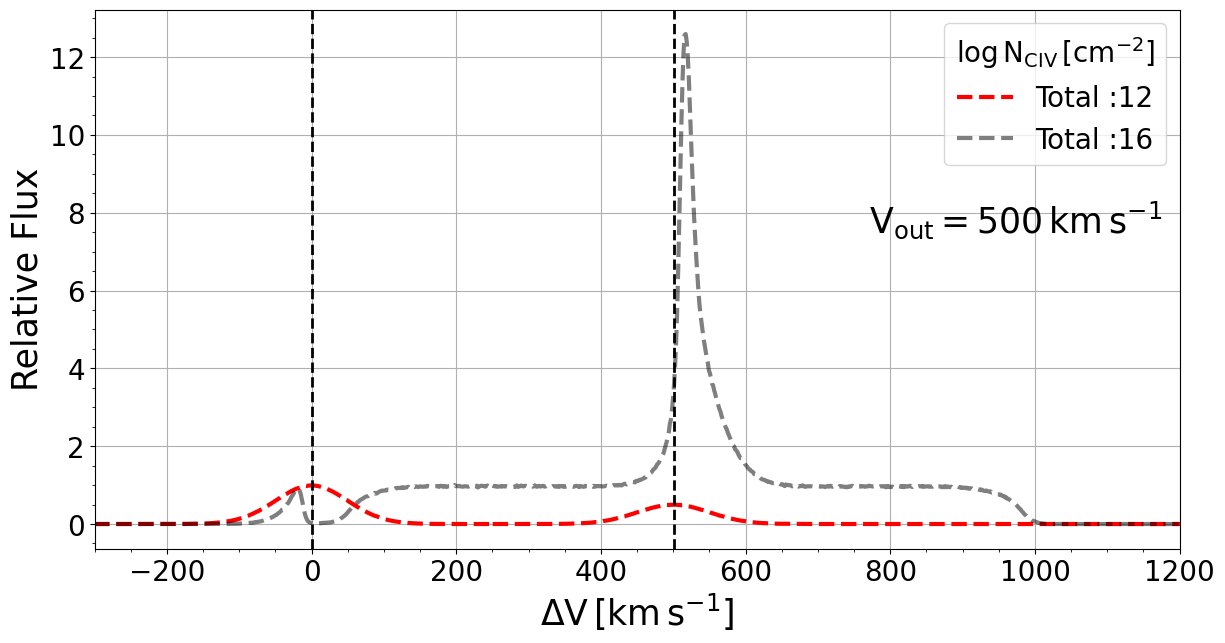

In [57]:
fig = plt.figure(1,figsize=(14,7))



atom ,v_ran,expand= 32 , 118, 500

index= 13
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# # normal_f = 1
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)

index = 12
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=3,label=f'Total :{index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=3)


# index = 13
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=3)


# index = 14
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=3)



# index = 15
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'m--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'m--',lw=3)



index = 16
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=3,alpha=0.5,label=f'Total :{index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=3,alpha=0.5)

# index = 14
# expand = 0
# xx_k,int_gau_K= gauss_func(normal_f,globals()[f'halo_vx_K_{atom}_{index}_{expand}'],0,50)
# xx_h,int_gau_H= gauss_func(normal_f,globals()[f'halo_vx_H_{atom}_{index}_{expand}'],500,50)
# plt.plot(xx_k,int_gau_K/normal_f,'k--',lw=3)
# plt.plot(xx_h,int_gau_H/normal_f/2,'k--',lw=3)

plt.xlim(-300, 1200)
plt.minorticks_on()
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=1,title=r'$\log{{\rm N}_{\rm C IV}}\,[\rm cm ^{-2}]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=dv,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
ymin = -0.1
ymax = 1
expand = 500

plt.text(770, 7.5 , f'$\\rm V_{{\\rm out}} = {int(expand)}\\,\\rm km\\,s^{{-1}}$', size=25, fontweight='bold')

# plt.ylim(ymin,ymax)
#400 -> 2.1
#500 -> 0.97

# plt.savefig(f'/home/jin/바탕화면/PPT_Total_gauss_source_density_{expand}km.png',bbox_inches='tight')

In [9]:
from celluloid import Camera

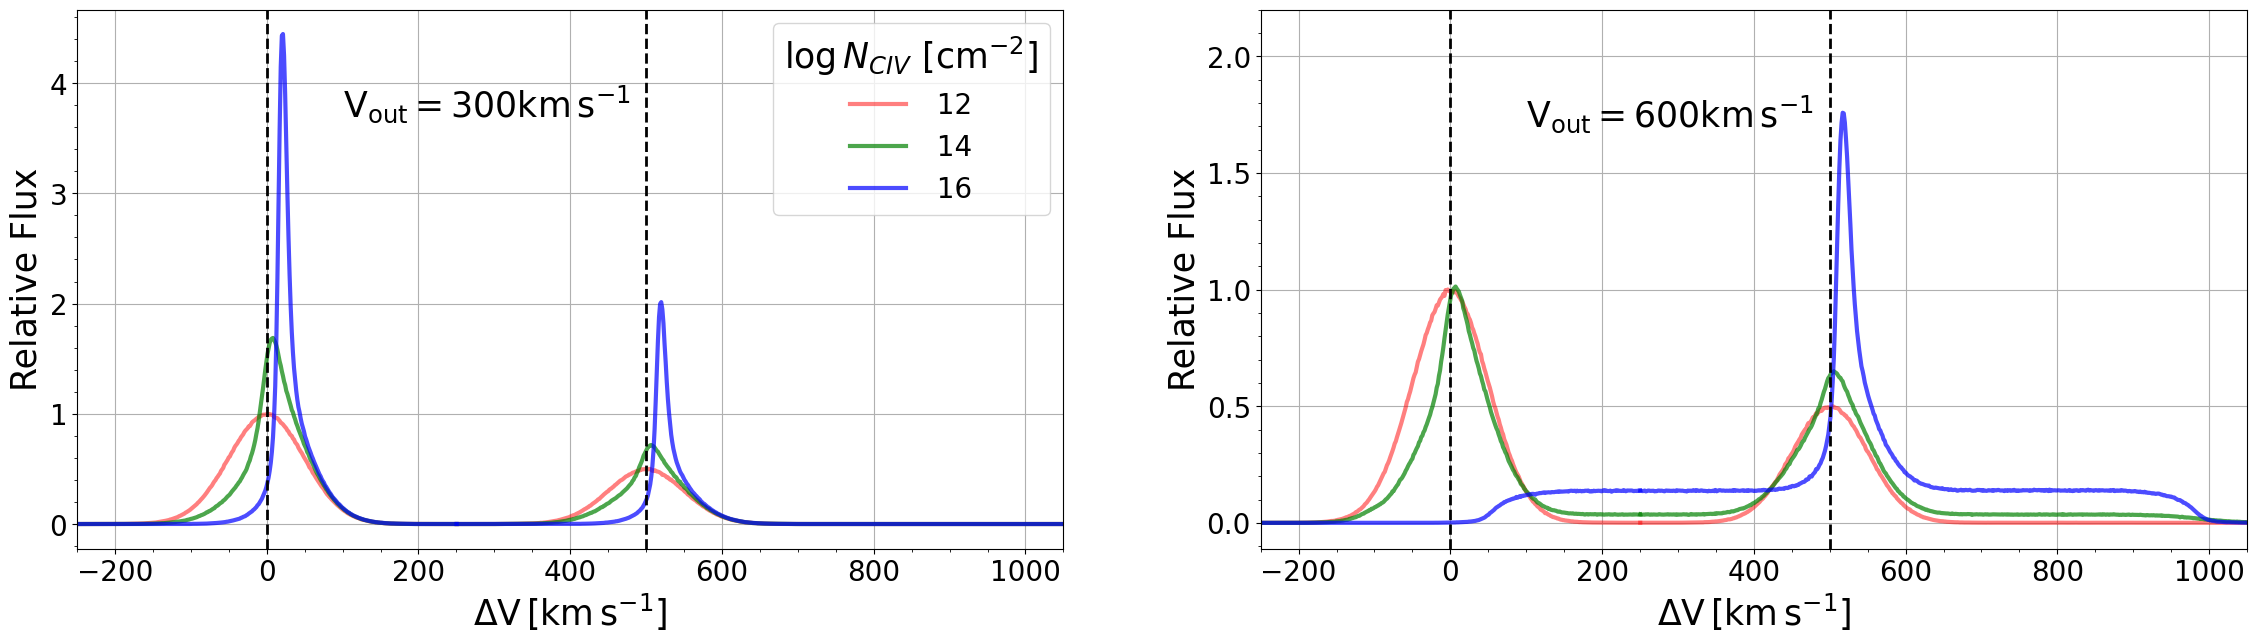

In [58]:
fig = plt.figure(1,figsize=(28,7))
atom ,v_ran= 50 , 118

plt.subplot(121)
index = 12
expand = 300
normal_f =  max(max(globals()[f'tot_vy_K_{atom}_{index}_{expand}']), max(globals()[f'tot_vy_H_{atom}_{index}_{expand}']))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5)
index = 14
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7)

index = 16
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7)

plt.text(100,3.7,r'$\rm V_{\rm out} = 300 \rm km\,s^{-1}$',fontsize=25)
plt.xlim(-250, 1050)
plt.minorticks_on()
plt.grid(True)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title = r'$\log{N_{CIV}}~[\rm cm^{-2}]$',title_fontsize=25,fontsize=20)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=500,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)

plt.subplot(122)
expand = 600
index = 12
normal_f =  max(max(globals()[f'tot_vy_K_{atom}_{index}_{expand}']), max(globals()[f'tot_vy_H_{atom}_{index}_{expand}']))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5)
index = 14
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7)

index = 16
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7)

plt.text(100,1.7,r'$\rm V_{\rm out} = 600 \rm km\,s^{-1}$',fontsize=25)
plt.xlim(-250, 1050)
plt.minorticks_on()
plt.grid(True)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.ylim(-0.11,2.2)
dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=500,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
# plt.legend(loc='upper right',fontsize= 25 , title = r'$\rm v_{\rm out} ~ [\rm km\,s^{-1}] $', title_fontsize=30)
# plt.savefig(f'/home/jin/바탕화면/Gaussian_300_600_velocity.pdf',bbox_inches='tight')

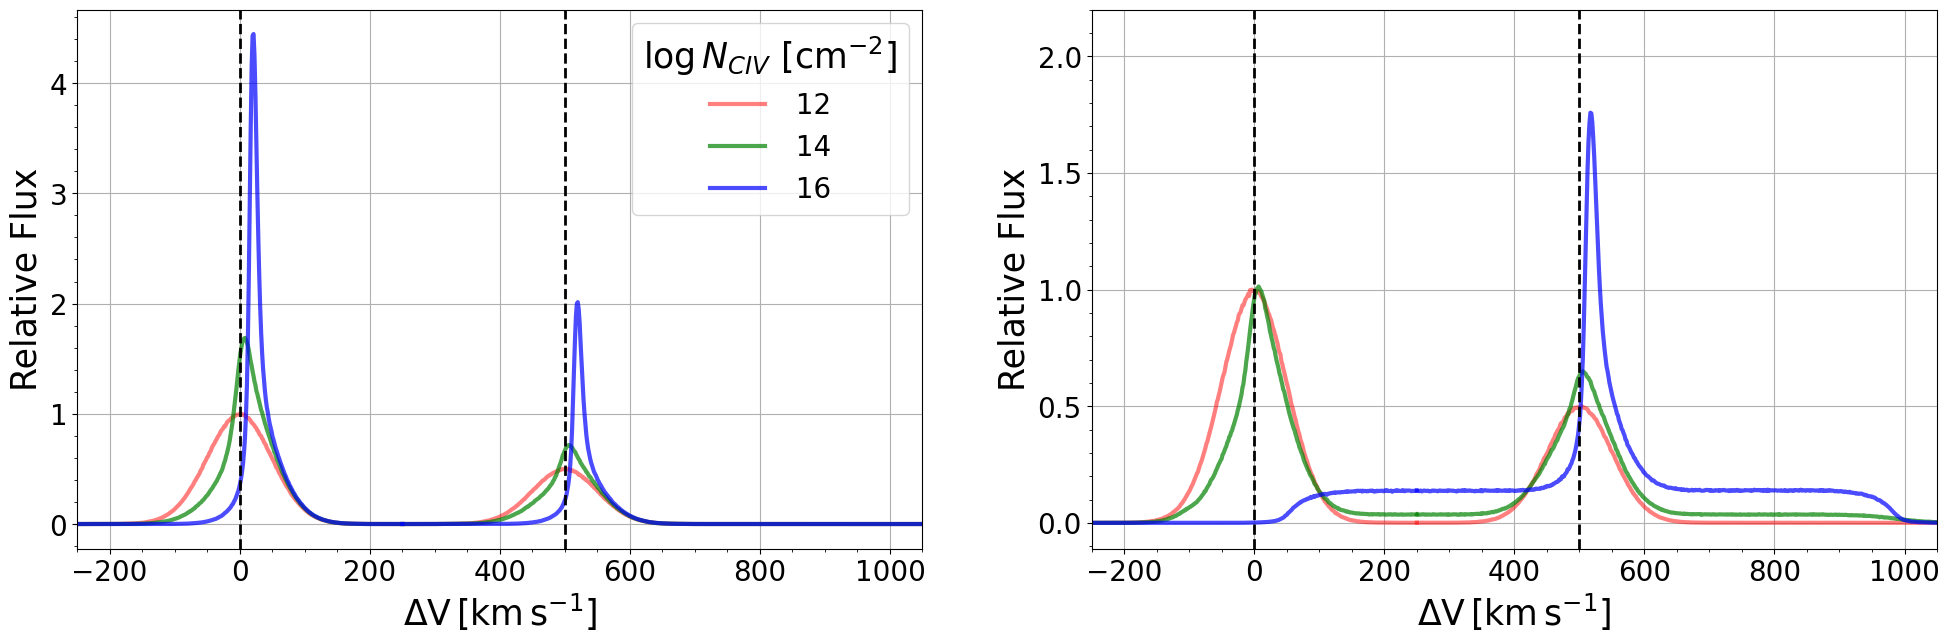

In [59]:
fig = plt.figure(1,figsize=(24,7))
atom ,v_ran= 50 , 118

plt.subplot(121)
index = 12
expand = 300
normal_f =  max(max(globals()[f'tot_vy_K_{atom}_{index}_{expand}']), max(globals()[f'tot_vy_H_{atom}_{index}_{expand}']))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5)
index = 14
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7)

index = 16
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7)

plt.xlim(-250, 1050)
plt.minorticks_on()
plt.grid(True)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title = r'$\log{N_{CIV}}~[\rm cm^{-2}]$',title_fontsize=25,fontsize=20)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=500,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)

plt.subplot(122)
expand = 600
index = 12
normal_f =  max(max(globals()[f'tot_vy_K_{atom}_{index}_{expand}']), max(globals()[f'tot_vy_H_{atom}_{index}_{expand}']))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=3,alpha=0.5)
index = 14
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=3,alpha=0.7)

index = 16
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7, label = f' {index}')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b-',lw=3,alpha=0.7)


plt.xlim(-250, 1050)
plt.minorticks_on()
plt.grid(True)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.ylim(-0.11,2.2)
dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=500,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
# plt.legend(loc='upper right',fontsize= 25 , title = r'$\rm v_{\rm out} ~ [\rm km\,s^{-1}] $', title_fontsize=30)
# plt.savefig(f'/home/jin/바탕화면/PPT_gauss_{expand}km.png',bbox_inches='tight')

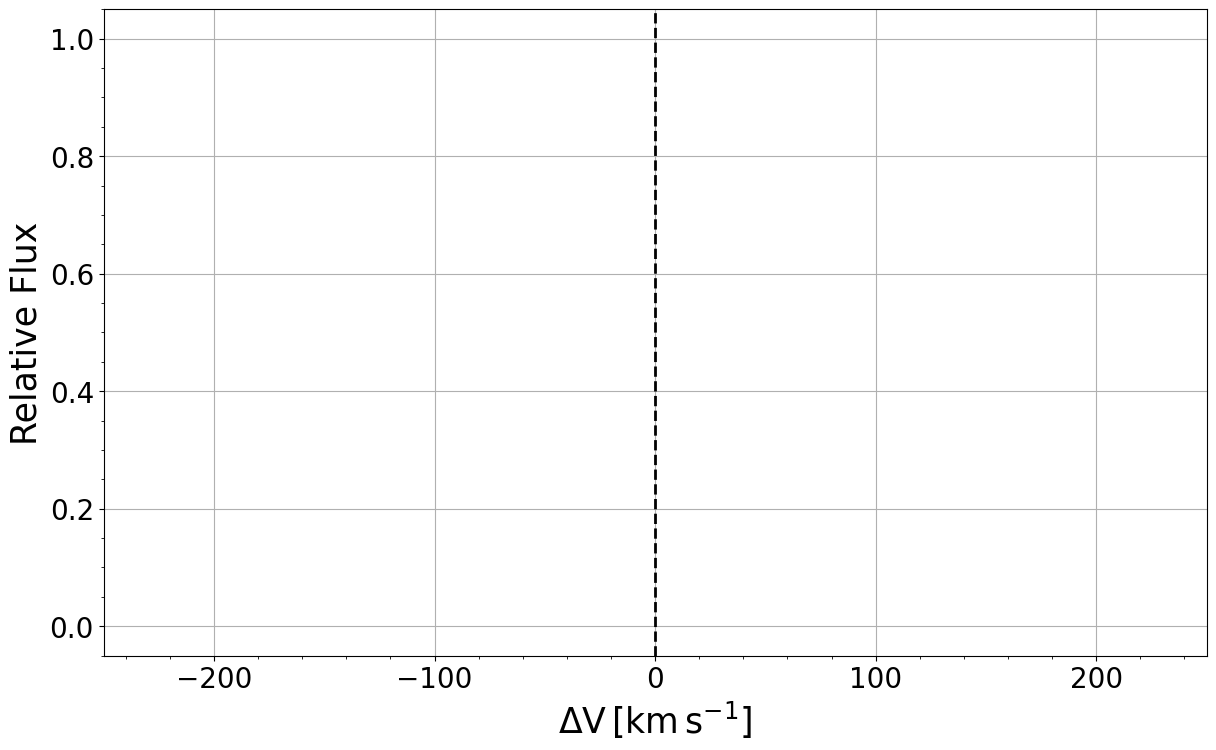

In [12]:
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(1, figsize=(14, 7))
camera = Camera(fig)

atom, v_ran = 50, 118
index = 15

for i in expand_vel:
    expand = i
    normal_f = max(max(globals()[f'tot_vy_K_{atom}_{index}_{expand}']), max(globals()[f'tot_vy_H_{atom}_{index}_{expand}']))
    plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'], globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f, 'k--', lw=3, alpha=0.5)
    # plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'], globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f, 'k--', lw=3, alpha=0.5)
    plt.text(80, 0.7, f'$\\rm v_{{\\rm out }} = {i} \\rm km\\,s^{{-1}}$', size=30)
    plt.tight_layout()
    camera.snap()  # 애니메이션에 추가

plt.xlim(-250, 250)
plt.minorticks_on()
plt.grid(True)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$', fontsize=25)
plt.ylabel(r'Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

dv = (C_IV_H_A / C_IV_K_A - 1) * cc_k
plt.axvline(x=0, ymin=0, ymax=5, color='k', linestyle='--', lw=2)

# Get the number of frames from the length of expand_vel
N = len(expand_vel)
target_duration_seconds = 4  # Target duration in seconds

# Calculate the appropriate interval to achieve the target duration
interval = (target_duration_seconds * 1000) / N

# Create the animation with the calculated interval
animation = camera.animate(interval=interval)
animation.save('Moving_with_out.mp4')

# Optionally, to display the animation inline in a Jupyter notebook
# HTML(animation.to


Text(850, 0.8, '$\\rm V_{\\rm out} = 500\\,\\rm km\\,s^{-1}$')

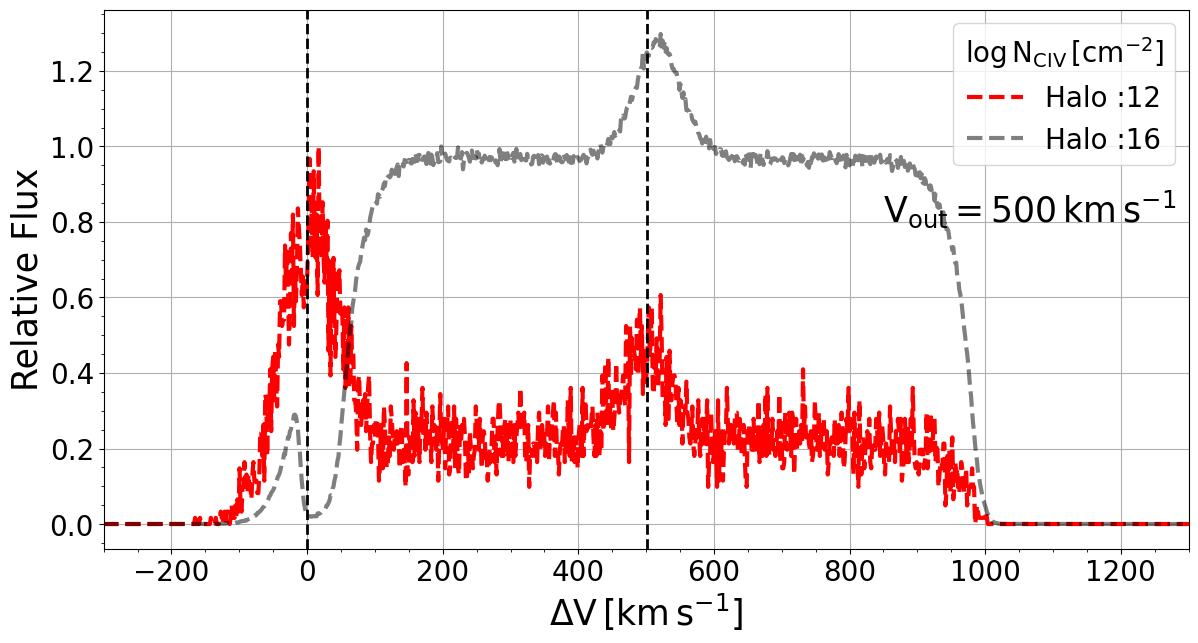

In [60]:
fig = plt.figure(1,figsize=(14,7))



atom ,v_ran,expand= 32 , 118, 500

index= 13
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# # normal_f = 1
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)


index = 12
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=3,label=f'Halo :{index}')
plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=3)


# index = 13
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=3)


# index = 14
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=3)



# index = 15
# # normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'m--',lw=3,label=f'Total :{index}')
# plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'m--',lw=3)



index = 16
# normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
normal_f =  max(globals()[f'halo_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'halo_vx_K_{atom}_{index}_{expand}'],globals()[f'halo_vy_K_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=3,alpha = 0.5, label=f'Halo :{index}')
plt.plot(globals()[f'halo_vx_H_{atom}_{index}_{expand}'],globals()[f'halo_vy_H_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=3,alpha = 0.5)
plt.xlim(-300, 1300)
plt.minorticks_on()
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=1,title=r'$\log{{\rm N}_{\rm C IV}}\,[\rm cm ^{-2}]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=dv,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
ymin = -0.1
ymax = 1
expand = 500
plt.text(850, ymax*(0.8), f'$\\rm V_{{\\rm out}} = {int(expand)}\\,\\rm km\\,s^{{-1}}$', size=25, fontweight='bold')

# plt.ylim(ymin,ymax)
#400 -> 2.1
#500 -> 0.97

# plt.savefig(f'/home/jin/바탕화면/PPT_Halo_gauss_source_density_{expand}km.png',bbox_inches='tight')

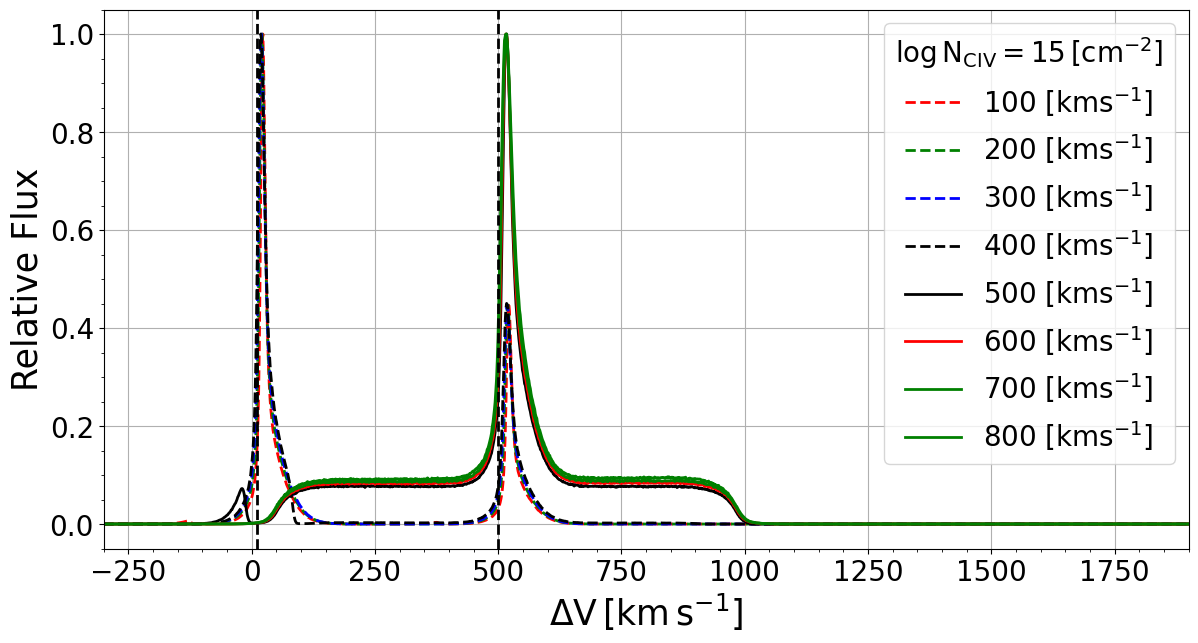

In [61]:
fig = plt.figure(1,figsize=(14,7))



atom ,v_ran,index= 32 , 118, 16
expand = 0
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
# plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
# plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)

expand = 100
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r--',lw=2)


expand = 200
normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g--',lw=2)

expand = 300
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'b--',lw=2)


expand = 400
# normal_f =  max(globals()[f'tot_vy_K_{atom}_{index}_{expand}'])
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'k--',lw=2)



expand = 500
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'k-',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'k-',lw=2)

expand = 600
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'r-',lw=2)

expand = 700
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=2)

expand = 800
normal_f =  max((globals()[f'tot_vy_K_{atom}_{index}_{expand}'].max() , globals()[f'tot_vy_H_{atom}_{index}_{expand}'].max()))
plt.plot(globals()[f'tot_vx_K_{atom}_{index}_{expand}'],globals()[f'tot_vy_K_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=2,label=f'{expand} $[\\rm km s^{{-1}}]$')
plt.plot(globals()[f'tot_vx_H_{atom}_{index}_{expand}'],globals()[f'tot_vy_H_{atom}_{index}_{expand}'] / normal_f ,'g-',lw=2)



plt.xlim(-300, 1900)
plt.minorticks_on()
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=1,title=r'$\log{{\rm N}_{\rm C IV}} =  15 \,[\rm cm ^{-2}]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

dv = (C_IV_H_A/C_IV_K_A -1)* cc_k
plt.axvline(x=dv,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
plt.axvline(x=11.8,ymin=0,ymax=5,color='k',linestyle='--',lw = 2)
ymin = -0.1
ymax = 1
expand = 400
# plt.text(770, ymax*(0.6), f'$\\rm V_{{\\rm exp}} = {int(expand)}\\,\\rm km\\,s^{{-1}}$', size=25, fontweight='bold')

# plt.xlim(450,650)

# plt.ylim(ymin,ymax)
#400 -> 2.1
#500 -> 0.97

# plt.savefig(f'/home/jin/바탕화면/PPT_gauss_source_density_{expand}km.png',bbox_inches='tight')

(1540.0, 1556.0)

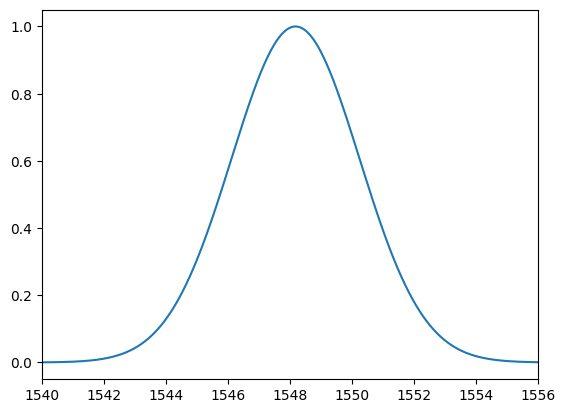

In [15]:
xx = np.arange(1530,1560,0.001)

t1 = (xx - C_IV_K_A)/C_IV_K_A * cc_k
t2 = 400
tt = np.exp(-(t1/t2)**2 / 2)
plt.plot(xx,tt)
plt.xlim(1540,1556)

In [16]:
C_IV_K_A

1548.187

In [17]:
cc_k

np.float64(299792.458)

(np.longdouble('1300000000000.0'), np.longdouble('7.9e+16'))

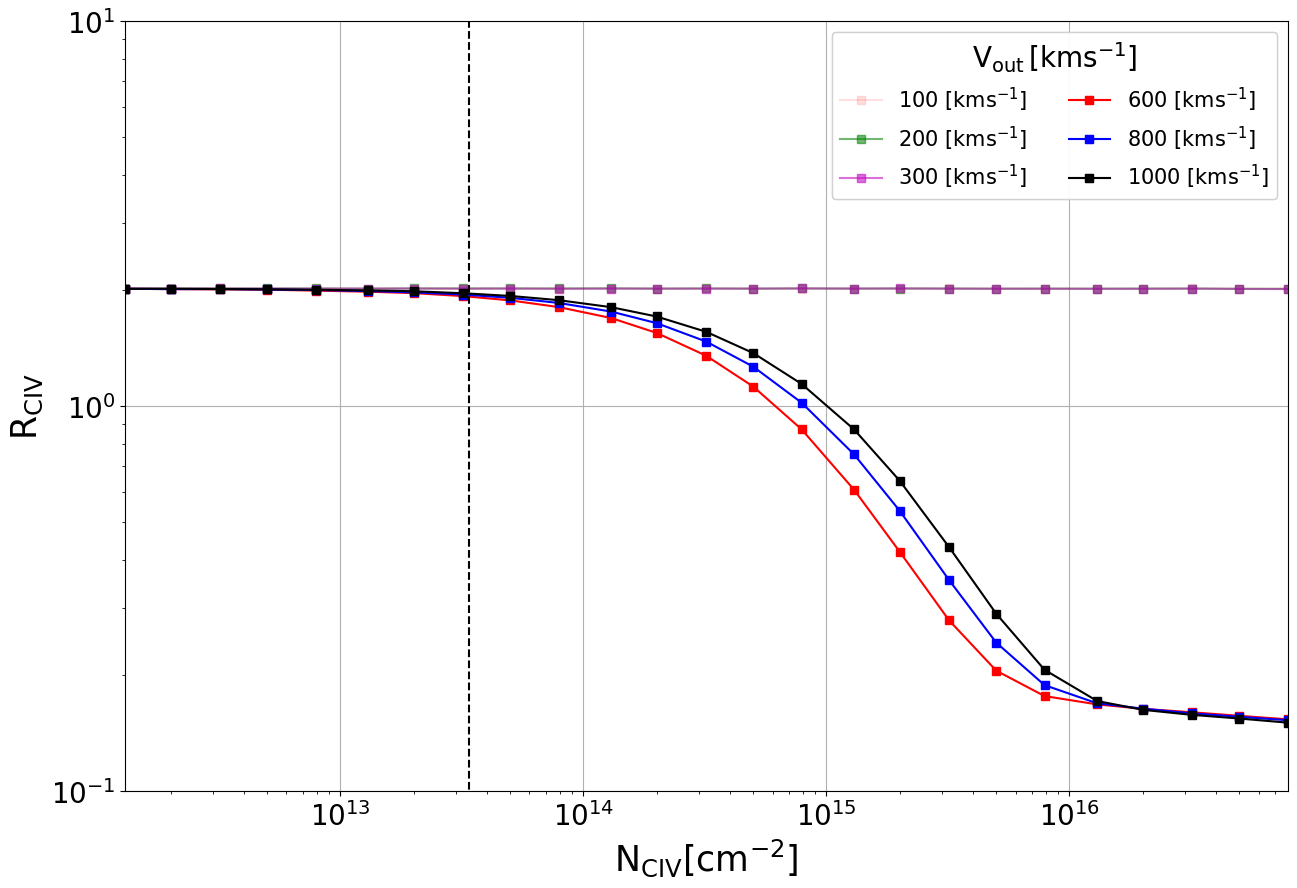

In [62]:

fig = plt.figure(1,figsize=(15,10))
def test(vexp):
    to = (total_N_c /7e13) * (50 / vexp)
    yy = np.exp(-to)
    return yy 

# yy = test(500)
# plt.plot(total_N_c , 2*yy , 'k-')

# yy = test(600)
# plt.plot(total_N_c , 2*yy,'b-')

# yy = test(800)
# plt.plot(total_N_c , 2*yy,'m-')

# yy = test(1000)
# plt.plot(total_N_c , 2*yy,'k-')

# yy = test(100)
# plt.plot(total_N_c , 2 *(yy),'r-')
# yy = test(200)
# plt.plot(total_N_c , 2 *(yy),'g-')
# yy = test(400)
# plt.plot(total_N_c , 2 *(yy),'k-')



# yy = test(500)
# plt.plot(total_N_c , 2*(1+yy) , 'k--')

# yy = test(600)
# plt.plot(total_N_c , 2*(1+yy),'b--')

# yy = test(1000)
# plt.plot(total_N_c , 2*(1+yy),'m--')
# yy = test(100)
# plt.plot(total_N_c , 2 *(1+yy),'r--')
# yy = test(200)
# plt.plot(total_N_c , 2 *(1+yy),'g--')
# yy = test(400)
# plt.plot(total_N_c , 2 *(1+yy),'k--')


import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def inf(x,y):
    summ = np.zeros(len(y))
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ

ratio_h = np.zeros((len(expand_vel),len(total_N_c)))
ratio_t = np.zeros((len(expand_vel),len(total_N_c)))

for ii,expand in enumerate(expand_vel):
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_2 = inf(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_h[ii][jj] = a_1/ a_2

            
            
            
            a_3 = inf(globals()[f'tot_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_4 = inf(globals()[f'tot_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_t[ii][jj] = a_3/ a_4


fig = plt.figure(1,figsize=(14,10))

# from matplotlib.ticker import ScalarFormatter
# # for ii, jj in enumerate(ee):


# expand = 0
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5,label=f'{expand} $[\\rm km s^{{-1}}]$')

# plt.plot(total_N_c, ratio_t[expand][:], 'r:', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
expand = 1
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=0.1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 2
# plt.plot(total_N_c, ratio_h[expand][:], 'go-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'g-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 3
# plt.plot(total_N_c, ratio_h[expand][:], 'mo-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'm-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 4
# plt.plot(total_N_c, ratio_h[expand][:], 'yo-',alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
# plt.plot(total_N_c, ratio_t[expand][:], 'k:', marker='o', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 5
# # plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5)
# plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')


expand = 6
# plt.plot(total_N_c, ratio_h[expand][:], 'bo-',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 8
# plt.plot(total_N_c, ratio_h[expand][:], 'mo-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'b-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 10
# plt.plot(total_N_c, ratio_h[expand][:], 'ko-',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'k-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

handles, labels = plt.gca().get_legend_handles_labels()
ff_t = plt.legend(handles[::], labels[::], title='$\mathrm{V}_\mathrm{out}\,[\mathrm{km s^{-1}}]$',ncol=2 ,title_fontsize=20, fontsize=15)



# Add the first legend back to the plot
plt.gca().add_artist(ff_t )

import matplotlib.lines as mlines
# outflow_line = mlines.Line2D([], [], color='black', linestyle='-', label='Outflow')
# inflow_line = mlines.Line2D([], [], color='black', linestyle='--',label='Total')

# # Add a second legend
# second_legend = plt.legend(handles=[outflow_line], loc='upper left', fontsize=20)



plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')
plt.axvline(x=N_CIV_0,ymin=-10,ymax=100,linestyle='--',color='k')
# plt.axhline(y=0.25,xmin=0,xmax=1,linestyle='dashdot',color='r')
# plt.axhline(y=0.3,xmin=0,xmax=1)
# plt.axhline(y=0.15,xmin=0,xmax=1)
plt.grid(True)
plt.yscale('log')
plt.yticks([0.1, 1, 10], fontsize=20)
plt.ylim(0.1,10)
plt.xlim(total_N_c.min(),total_N_c.max())
# plt.savefig('/home/jin/바탕화면/PPT_Gauss_doublet_total.png',bbox_inches='tight')

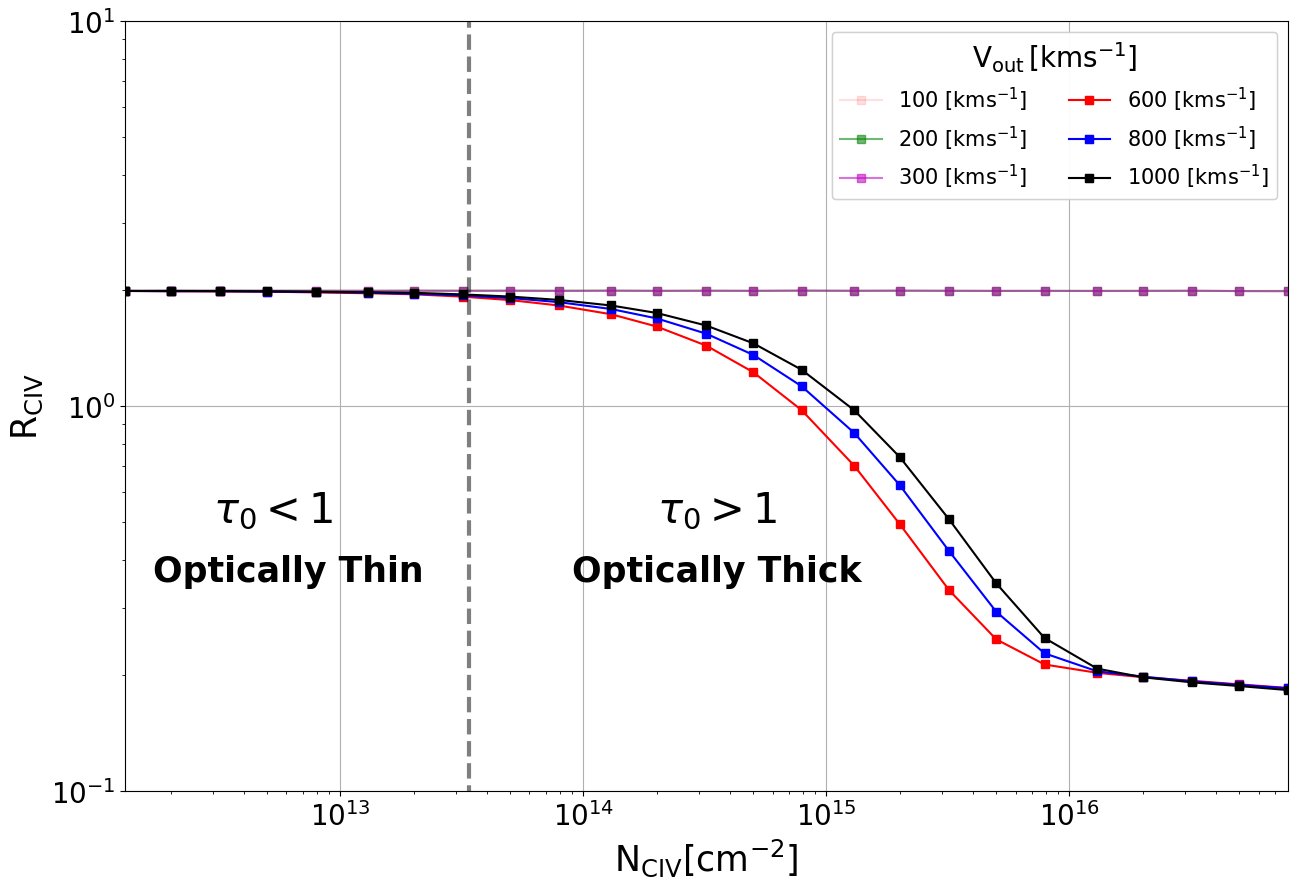

In [ ]:

fig = plt.figure(1,figsize=(15,10))
def test(vexp):
    to = (total_N_c /7e13) * (50 / vexp)
    yy = np.exp(-to)
    return yy 

# yy = test(500)
# plt.plot(total_N_c , 2*yy , 'k-')

# yy = test(600)
# plt.plot(total_N_c , 2*yy,'b-')

# yy = test(800)
# plt.plot(total_N_c , 2*yy,'m-')

# yy = test(1000)
# plt.plot(total_N_c , 2*yy,'k-')

# yy = test(100)
# plt.plot(total_N_c , 2 *(yy),'r-')
# yy = test(200)
# plt.plot(total_N_c , 2 *(yy),'g-')
# yy = test(400)
# plt.plot(total_N_c , 2 *(yy),'k-')



# yy = test(500)
# plt.plot(total_N_c , 2*(1+yy) , 'k--')

# yy = test(600)
# plt.plot(total_N_c , 2*(1+yy),'b--')

# yy = test(1000)
# plt.plot(total_N_c , 2*(1+yy),'m--')
# yy = test(100)
# plt.plot(total_N_c , 2 *(1+yy),'r--')
# yy = test(200)
# plt.plot(total_N_c , 2 *(1+yy),'g--')
# yy = test(400)
# plt.plot(total_N_c , 2 *(1+yy),'k--')


import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def inf(x,y):
    summ = np.zeros(len(y))
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ

ratio_h = np.zeros((len(expand_vel),len(total_N_c)))
ratio_t = np.zeros((len(expand_vel),len(total_N_c)))

for ii,expand in enumerate(expand_vel):
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_2 = inf(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_h[ii][jj] = a_1/ a_2

            
            
            
            a_3 = inf(globals()[f'tot_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_4 = inf(globals()[f'tot_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_H_{atom_n}_{index}_{expand}'].to_numpy())


            xx_k= np.where((globals()[f'tot_vx_K_{atom_n}_{index}_{expand}']>= -250) & (globals()[f'tot_vx_K_{atom_n}_{index}_{expand}']<=250))  
            yy_k = globals()[f'tot_vy_K_{atom_n}_{index}_{expand}'][xx_k]
            

            xx_h= np.where((globals()[f'tot_vx_H_{atom_n}_{index}_{expand}'] >= 250) & (globals()[f'tot_vx_H_{atom_n}_{index}_{expand}'] <= 750)) 
            yy_h = globals()[f'tot_vy_H_{atom_n}_{index}_{expand}'][xx_h]        


            ratio_t[ii][jj] = np.sum(yy_k,0) / np.sum(yy_h,0)

fig = plt.figure(1,figsize=(14,10))

# from matplotlib.ticker import ScalarFormatter
# # for ii, jj in enumerate(ee):


# expand = 0
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5,label=f'{expand} $[\\rm km s^{{-1}}]$')

# plt.plot(total_N_c, ratio_t[expand][:], 'r:', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
expand = 1
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=0.1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 2
# plt.plot(total_N_c, ratio_h[expand][:], 'go-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'g-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 3
# plt.plot(total_N_c, ratio_h[expand][:], 'mo-',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'm-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 4
# plt.plot(total_N_c, ratio_h[expand][:], 'yo-',alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
# plt.plot(total_N_c, ratio_t[expand][:], 'k:', marker='o', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 5
# # plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5)
# plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')


expand = 6
# plt.plot(total_N_c, ratio_h[expand][:], 'bo-',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 8
# plt.plot(total_N_c, ratio_h[expand][:], 'mo-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'b-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 10
# plt.plot(total_N_c, ratio_h[expand][:], 'ko-',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'k-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

handles, labels = plt.gca().get_legend_handles_labels()
ff_t = plt.legend(handles[::], labels[::], title='$\mathrm{V}_\mathrm{out}\,[\mathrm{km s^{-1}}]$',ncol=2 ,title_fontsize=20, fontsize=15)



# Add the first legend back to the plot
plt.gca().add_artist(ff_t )

import matplotlib.lines as mlines
# outflow_line = mlines.Line2D([], [], color='black', linestyle='-', label='Outflow')
# inflow_line = mlines.Line2D([], [], color='black', linestyle='--',label='Total')

# # Add a second legend
# second_legend = plt.legend(handles=[outflow_line], loc='upper left', fontsize=20)



plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')
plt.axvline(x=N_CIV_0,ymin=-10,ymax=100,linestyle='--',color='k',lw=3,alpha=0.5)
plt.text(x=3*1e12, y=0.5, s=r'$\tau_0 < 1$', fontsize=30, fontweight='bold')
plt.text(x=1.7*1e12, y=0.35, s=r'Optically Thin', fontsize=25, fontweight='bold')


plt.text(x=2*1e14, y=0.5, s=r'$\tau_0 > 1$', fontsize=30, fontweight='bold')
plt.text(x=0.9*1e14, y=0.35, s=r'Optically Thick', fontsize=25, fontweight='bold')
# plt.axhline(y=0.25,xmin=0,xmax=1,linestyle='dashdot',color='r')
# plt.axhline(y=1/5.5,xmin=0,xmax=1)
# plt.axhline(y=0.18,xmin=0,xmax=1)
plt.grid(True)
# plt.yscale('log')
plt.yticks([0.1, 1,2, 10], fontsize=20)
plt.yscale('log')
plt.ylim(0.1,10)
plt.xlim(total_N_c.min(),total_N_c.max())
# plt.savefig('/home/jin/바탕화면/Gauss_doublet_total.png',bbox_inches='tight')

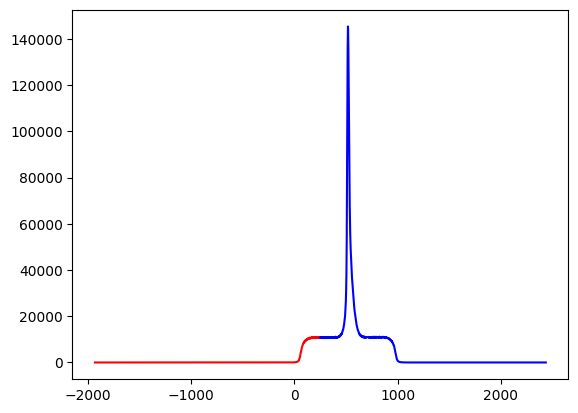

In [73]:
atom_n = 79
index= 16
expand = 600
vkx= globals()[f'tot_vx_K_{atom_n}_{index}_{expand}']
vky =globals()[f'tot_vy_K_{atom_n}_{index}_{expand}']

vhx= globals()[f'tot_vx_H_{atom_n}_{index}_{expand}']
vhy =globals()[f'tot_vy_H_{atom_n}_{index}_{expand}']


plt.plot(vkx,vky,'r-')
plt.plot(vhx,vhy,'b-')

(np.longdouble('1300000000000.0'), np.longdouble('7.9e+16'))

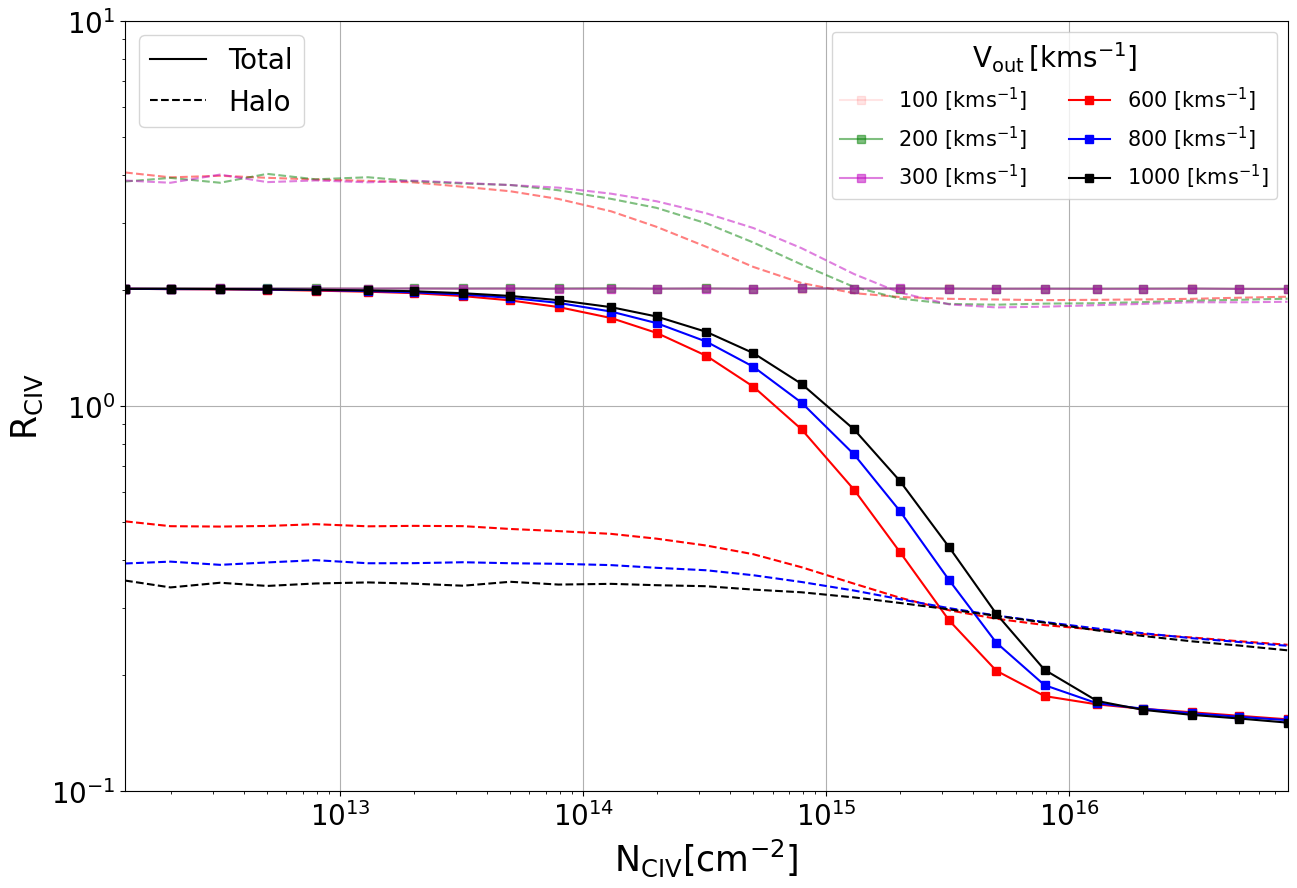

In [19]:

fig = plt.figure(1,figsize=(15,10))
def test(vexp):
    to = (total_N_c /7e13) * (50 / vexp)
    yy = np.exp(-to)
    return yy 

# yy = test(500)
# plt.plot(total_N_c , 2*yy , 'k-')

# yy = test(600)
# plt.plot(total_N_c , 2*yy,'b-')

# yy = test(800)
# plt.plot(total_N_c , 2*yy,'m-')

# yy = test(1000)
# plt.plot(total_N_c , 2*yy,'k-')

# yy = test(100)
# plt.plot(total_N_c , 2 *(yy),'r-')
# yy = test(200)
# plt.plot(total_N_c , 2 *(yy),'g-')
# yy = test(400)
# plt.plot(total_N_c , 2 *(yy),'k-')



# yy = test(500)
# plt.plot(total_N_c , 2*(1+yy) , 'k--')

# yy = test(600)
# plt.plot(total_N_c , 2*(1+yy),'b--')

# yy = test(1000)
# plt.plot(total_N_c , 2*(1+yy),'m--')
# yy = test(100)
# plt.plot(total_N_c , 2 *(1+yy),'r--')
# yy = test(200)
# plt.plot(total_N_c , 2 *(1+yy),'g--')
# yy = test(400)
# plt.plot(total_N_c , 2 *(1+yy),'k--')


import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def inf(x,y):
    summ = np.zeros(len(y))
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ

ratio_h = np.zeros((len(expand_vel),len(total_N_c)))
ratio_t = np.zeros((len(expand_vel),len(total_N_c)))

for ii,expand in enumerate(expand_vel):
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_2 = inf(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_h[ii][jj] = a_1/ a_2

            a_3 = inf(globals()[f'tot_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_4 = inf(globals()[f'tot_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_t[ii][jj] = a_3/ a_4


fig = plt.figure(1,figsize=(14,10))

# from matplotlib.ticker import ScalarFormatter
# # for ii, jj in enumerate(ee):


# expand = 0
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5,label=f'{expand} $[\\rm km s^{{-1}}]$')

# plt.plot(total_N_c, ratio_t[expand][:], 'r:', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
expand = 1
plt.plot(total_N_c, ratio_h[expand][:], 'r--',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=0.1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 2
plt.plot(total_N_c, ratio_h[expand][:], 'g--',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'g-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 3
plt.plot(total_N_c, ratio_h[expand][:], 'm--',alpha=0.5)
plt.plot(total_N_c, ratio_t[expand][:], 'm-', marker='s', alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 4
# plt.plot(total_N_c, ratio_h[expand][:], 'yo-',alpha=0.5,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
# plt.plot(total_N_c, ratio_t[expand][:], 'k:', marker='o', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

# expand = 5
# # plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5)
# plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')


expand = 6
plt.plot(total_N_c, ratio_h[expand][:], 'r--',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 8
plt.plot(total_N_c, ratio_h[expand][:], 'b--',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'b-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 10
plt.plot(total_N_c, ratio_h[expand][:], 'k--',alpha=1)
plt.plot(total_N_c, ratio_t[expand][:], 'k-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

handles, labels = plt.gca().get_legend_handles_labels()
ff_t = plt.legend(handles[::], labels[::], title='$\mathrm{V}_\mathrm{out}\,[\mathrm{km s^{-1}}]$',ncol=2 ,title_fontsize=20, fontsize=15)



# Add the first legend back to the plot
plt.gca().add_artist(ff_t )

import matplotlib.lines as mlines
outflow_line = mlines.Line2D([], [], color='black', linestyle='-', label='Total')
inflow_line = mlines.Line2D([], [], color='black', linestyle='--',label='Halo')

# # Add a second legend
second_legend = plt.legend(handles=[outflow_line,inflow_line], loc='upper left', fontsize=20)



plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')

# plt.axhline(y=0.25,xmin=0,xmax=1,linestyle='dashdot',color='r')
# plt.axhline(y=0.3,xmin=0,xmax=1)
# plt.axhline(y=0.15,xmin=0,xmax=1)
plt.grid(True)
plt.yscale('log')
plt.yticks([0.1, 1, 10], fontsize=20)
plt.ylim(0.1,10)
plt.xlim(total_N_c.min(),total_N_c.max())
# plt.savefig('/home/jin/바탕화면/PPT_Gauss_doublet_total_with_halo.pdf',bbox_inches='tight')

(0.1, 10.0)

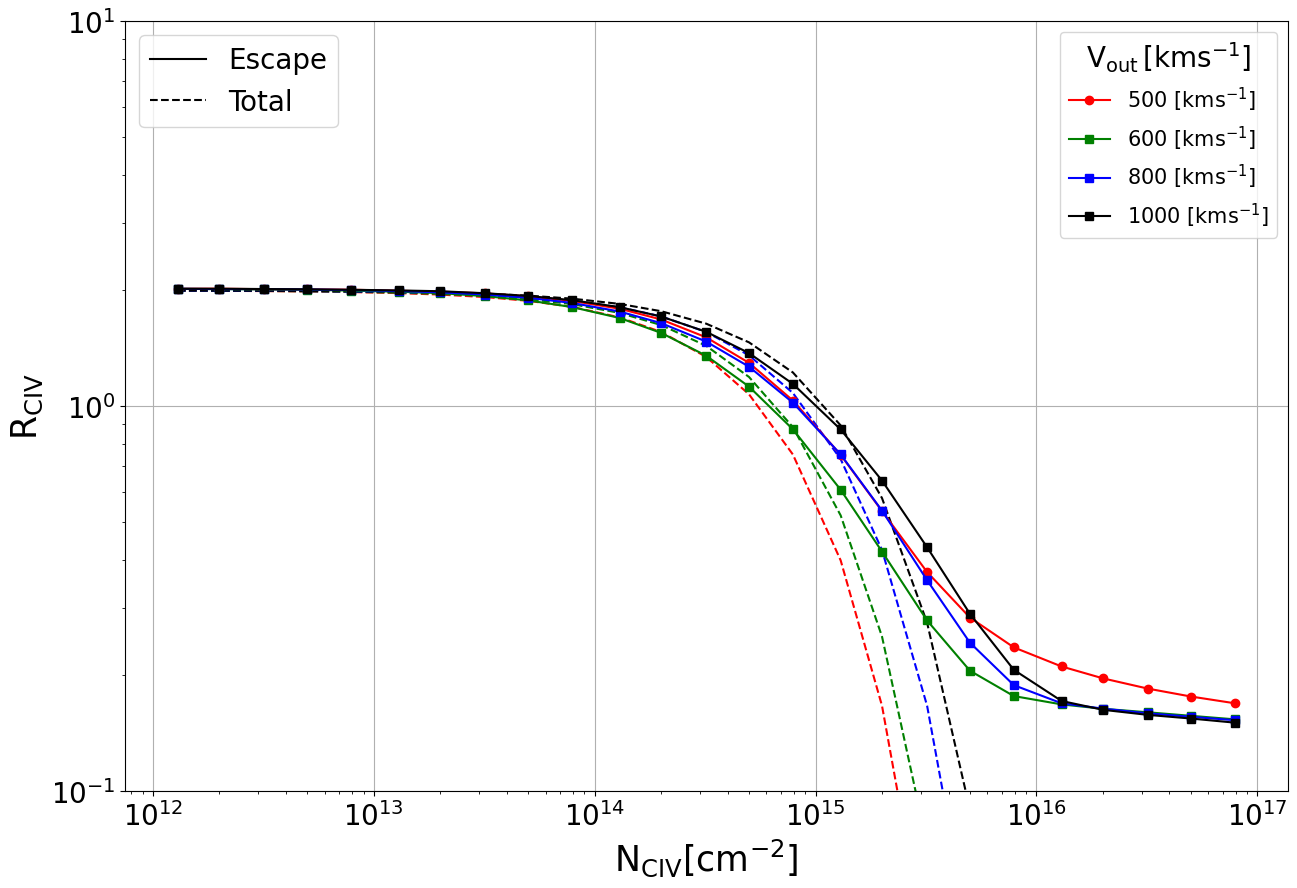

In [20]:

fig = plt.figure(1,figsize=(15,10))
def test(vexp):
    to = (total_N_c /1.9e13) * (11.8 / vexp)
    yy = np.exp(-to)
    return yy 

yy = test(500)
plt.plot(total_N_c , 2*yy , 'r--')

yy = test(600)
plt.plot(total_N_c , 2*yy,'g--')


yy = test(800)
plt.plot(total_N_c , 2*yy,'b--')


yy = test(1000)
plt.plot(total_N_c , 2*yy,'k--')






import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def inf(x,y):
    summ = np.zeros(len(y))
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ

ratio_h = np.zeros((len(expand_vel),len(total_N_c)))
ratio_t = np.zeros((len(expand_vel),len(total_N_c)))

for ii,expand in enumerate(expand_vel):
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_2 = inf(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_h[ii][jj] = a_1/ a_2

            a_3 = inf(globals()[f'tot_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_4 = inf(globals()[f'tot_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_t[ii][jj] = a_3/ a_4


fig = plt.figure(1,figsize=(14,10))


expand = 5
# plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=0.5,label=f'halo {expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'r-', marker='o', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')


expand = 6
# plt.plot(total_N_c, ratio_h[expand][:], 'go-',alpha=1,label=f'halo {expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'g-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 8
# plt.plot(total_N_c, ratio_h[expand][:], 'bo-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'b-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 10
# plt.plot(total_N_c, ratio_h[expand][:], 'ko-',alpha=1,label=f'halo {expand}00 $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[expand][:], 'k-', marker='s', alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

handles, labels = plt.gca().get_legend_handles_labels()
ff_t = plt.legend(handles[::], labels[::], title='$\mathrm{V}_\mathrm{out}\,[\mathrm{km s^{-1}}]$', title_fontsize=20, fontsize=15)



# Add the first legend back to the plot
plt.gca().add_artist(ff_t )

import matplotlib.lines as mlines
outflow_line = mlines.Line2D([], [], color='black', linestyle='-', label='Escape')
inflow_line = mlines.Line2D([], [], color='black', linestyle='--',label='Total')

# # Add a second legend
second_legend = plt.legend(handles=[outflow_line, inflow_line], loc='upper left', fontsize=20)



plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')

# plt.axhline(y=0.15,xmin=0,xmax=1)
# plt.axhline(y=0.9,xmin=0,xmax=1)
plt.grid(True)
plt.yscale('log')
plt.yticks([0.1, 1, 10], fontsize=20)
plt.ylim(0.1,10)
# plt.savefig('/home/jin/바탕화면/PPT_ratio_Total.png',bbox_inches='tight')

In [21]:
(3.39+3.39*2)/2

5.085

(1.0, 5.0)

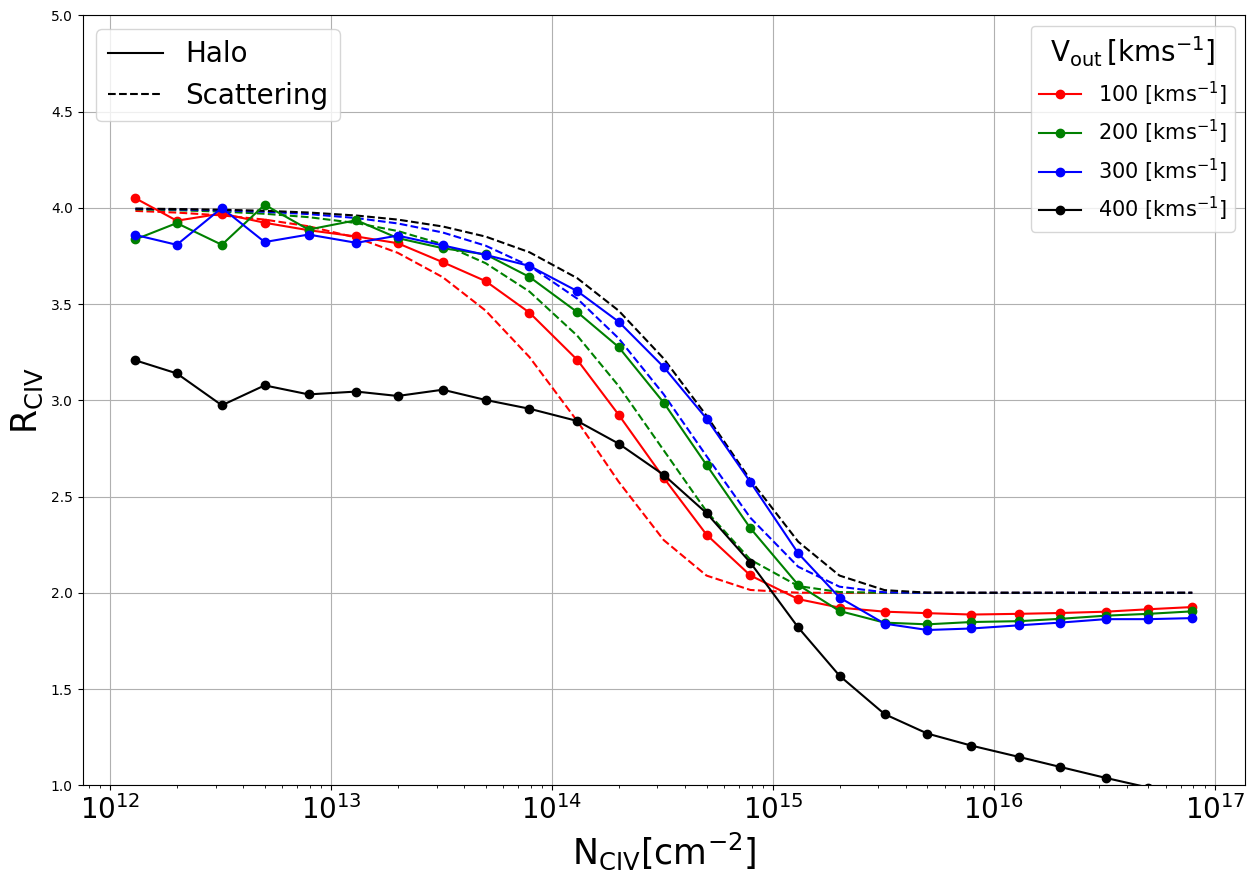

In [22]:

fig = plt.figure(1,figsize=(15,10))
def test(vexp):
    to = (total_N_c /1.9e13) * (11.8/ vexp )
    yy = np.exp(-to)
    return yy 



yy = test(100)
plt.plot(total_N_c , 2*(1+yy) , 'r--')

yy = test(200)
plt.plot(total_N_c , 2*(1+yy) , 'g--')

yy = test(300)
plt.plot(total_N_c , 2*(1+yy),'b--')

yy = test(400)
plt.plot(total_N_c , 2*(1+yy),'k--')



import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def inf(x,y):
    summ = np.zeros(len(y))
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ

ratio_h = np.zeros((len(expand_vel),len(total_N_c)))
ratio_t = np.zeros((len(expand_vel),len(total_N_c)))

for ii,expand in enumerate(expand_vel):
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_2 = inf(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'halo_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_h[ii][jj] = a_1/ a_2

            a_3 = inf(globals()[f'tot_x_K_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_K_{atom_n}_{index}_{expand}'].to_numpy())
            a_4 = inf(globals()[f'tot_x_H_{atom_n}_{index}_{expand}'].to_numpy(),globals()[f'tot_y_H_{atom_n}_{index}_{expand}'].to_numpy())
            ratio_t[ii][jj] = a_3/ a_4


fig = plt.figure(1,figsize=(14,10))


expand = 1
plt.plot(total_N_c, ratio_h[expand][:], 'ro-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 2
plt.plot(total_N_c, ratio_h[expand][:], 'go-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 3
plt.plot(total_N_c, ratio_h[expand][:], 'bo-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')

expand = 4
plt.plot(total_N_c, ratio_h[expand][:], 'ko-',alpha=1,label=f'{expand}00 $[\\rm km s^{{-1}}]$')



handles, labels = plt.gca().get_legend_handles_labels()
ff_t = plt.legend(handles[::], labels[::], title='$\mathrm{V}_\mathrm{out}\,[\mathrm{km s^{-1}}]$', title_fontsize=20, fontsize=15)



# Add the first legend back to the plot
plt.gca().add_artist(ff_t )

import matplotlib.lines as mlines
outflow_line = mlines.Line2D([], [], color='black', linestyle='-', label='Halo')
inflow_line = mlines.Line2D([], [], color='black', linestyle='--',label='Scattering')

# # Add a second legend
second_legend = plt.legend(handles=[outflow_line, inflow_line], loc='upper left', fontsize=20)



plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')

plt.axhline(y=0.15,xmin=0,xmax=1)
# plt.axhline(y=0.9,xmin=0,xmax=1)
plt.grid(True)
# plt.yscale('log')
# plt.yticks([0.1, 1, 10], fontsize=20)
plt.ylim(1,5)
# plt.savefig('/home/jin/바탕화면/PPT_ratio_halo.png',bbox_inches='tight')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4')])

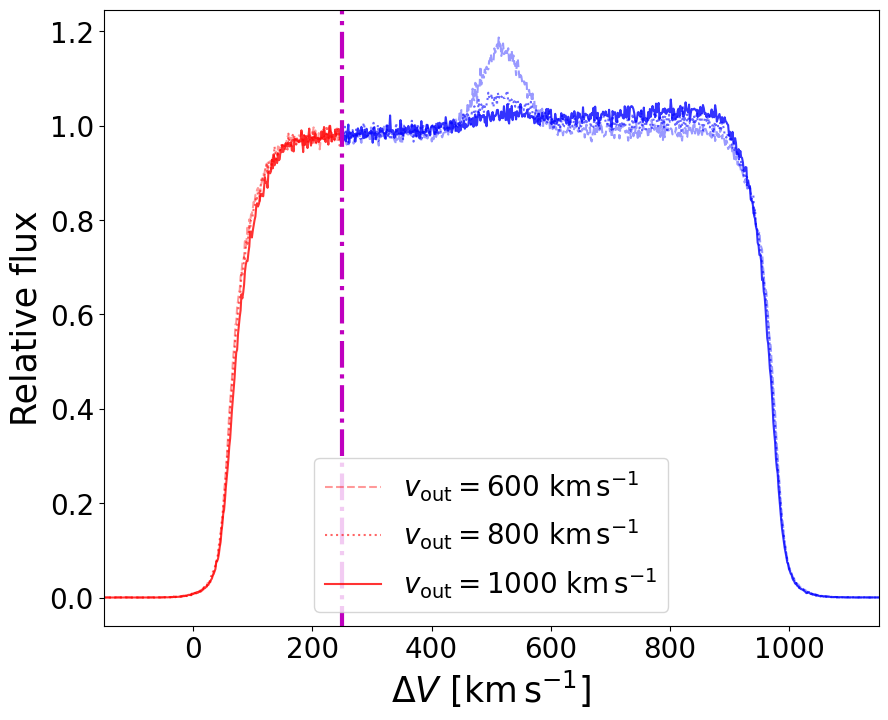

In [23]:
fig = plt.figure(1,figsize=(10,8))


atom_n = 50
index = 16

# expand = 0
# normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
# plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'r--',alpha=0.7)

# expand = 100
# normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
# plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'g--',alpha=0.7)

# expand = 200
# normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
# plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'b--',alpha=0.7)

expand = 600
# normal_f = 1
normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'r--',alpha=0.4,label=r'$v_{\rm out} = 600 ~\rm km\,s^{-1}$')
plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}']/normal_f,'b--',alpha=0.4)

expand = 800
# normal_f = 1
normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'r:',alpha=0.6,label=r'$v_{\rm out} = 800 ~\rm km\,s^{-1}$')
plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}']/normal_f,'b:',alpha=0.6)


expand = 1000
normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}']/normal_f,'r-',alpha=0.8,label=r'$v_{\rm out} = 1000 ~ \rm km\,s^{-1}$')
plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}']/normal_f,'b-',alpha=0.8)

plt.legend(fontsize=20)
# plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}'])
# plt.axvline(x=1000,ymin = -10,ymax=10,linestyle='dashdot',color='k')
plt.axvline(x=250,ymin = -10,ymax=10,linestyle='dashdot',color='m',lw=3)
# plt.axvline(x=0,ymin = -10,ymax=10,linestyle='dashdot',color='k')

# plt.gca().yaxis.set_major_formatter()

plt.xlim(-150,1150)



plt.xlabel(r'$\Delta V ~ [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig('/home/jin/바탕화면/PPT_gauss_source_ratio_halo_total_high_col_index_16_1.png',bbox_inches='tight')



(-150.0, 500.0)

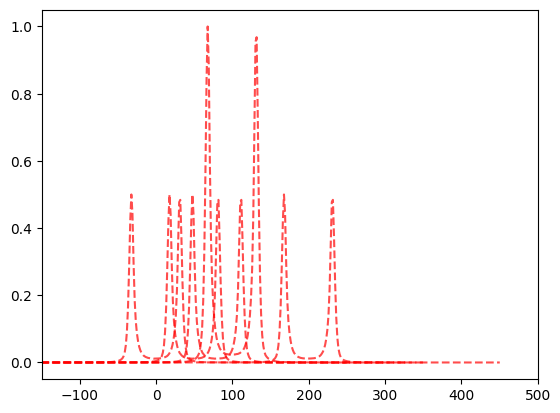

In [24]:
atom_n = 50
index = 16

expand = 0
normal_f = globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'].max()
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'] /normal_f/2  ,'r--',alpha=0.7)
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}']+50,globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'] /normal_f/2  ,'r--',alpha=0.7)
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}']+80,globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'] /normal_f/2  ,'r--',alpha=0.7)
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}']+100,globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'] /normal_f/1  ,'r--',alpha=0.7)
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}']+200,globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'] /normal_f/2  ,'r--',alpha=0.7)


plt.xlim(-150,500)

Enoughly thick, 

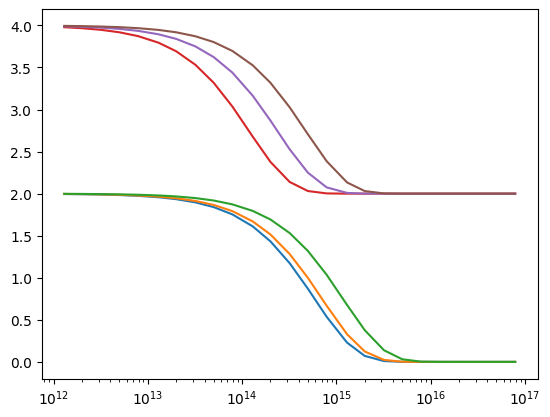

In [25]:
def test(vexp):
    to = (total_N_c /6e13) * (50 / vexp)
    yy = np.exp(-to)
    return yy 
yy = test(500)
plt.plot(total_N_c , 2*yy)

yy = test(600)
plt.plot(total_N_c , 2*yy)

yy = test(1000)
plt.plot(total_N_c , 2*yy)

yy = test(100)
plt.plot(total_N_c , 2 *(1+yy))
yy = test(200)
plt.plot(total_N_c , 2 *(1+yy))
yy = test(400)
plt.plot(total_N_c , 2 *(1+yy))

# plt.plot(total_N_c , 2 *(yy))

plt.xscale('log')

(-250.0, 1200.0)

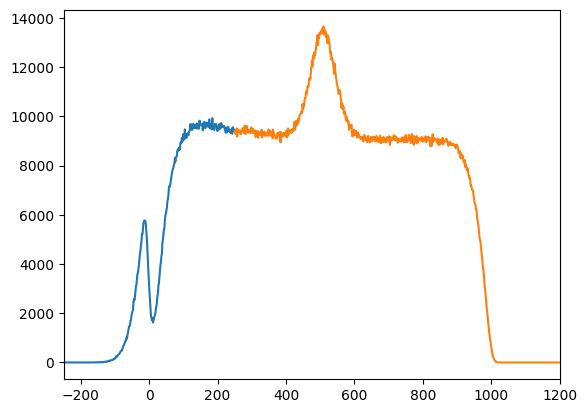

In [26]:
atom_n = 50
index = 15
expand = 500
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}'])
plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}'])
plt.xlim(-250,1200)

In [27]:
(1 + 2 * 1000/cc_k)*C_IV_H_A - C_IV_H_A 

np.float64(10.345637180772428)

(1547.687, 1549.0)

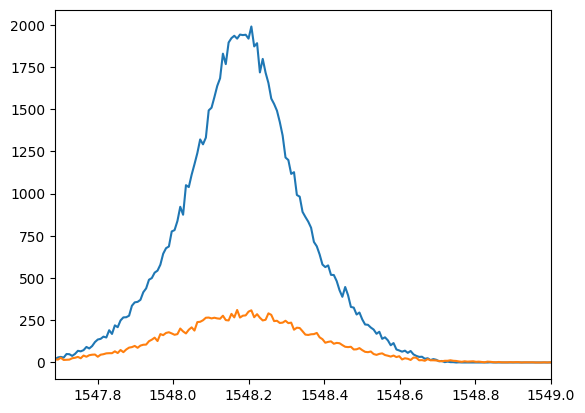

In [28]:
atom_n = 50
index = 12

expand = 100
plt.plot(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'],globals()[f'halo_y_K_{atom_n}_{index}_{expand}'])

expand = 300
plt.plot(globals()[f'halo_x_K_{atom_n}_{index}_{expand}'],globals()[f'halo_y_K_{atom_n}_{index}_{expand}'])

# plt.plot(globals()[f'halo_x_H_{atom_n}_{index}_{expand}'],globals()[f'halo_y_H_{atom_n}_{index}_{expand}'])
plt.xlim(C_IV_K_A-0.5,1549)